# Sentiment Analysis

- **VADER**: a lexicon-based (or rule-based) model. Breifly, this model has its own dictionary (list of negative and positive words), and it tries to find the words from the text. Consequently it assigns scores depending on found words. Custom words can be added to the dictionary.

- **Twitter-roBERTa-base**: a deep learning based model, which was  trained on 168.86M tweets until the end of September 2022, and finetuned for sentiment analysis with the TweetEval benchmark. 

Both models does not require training, i.e. they can be used directly out of package.

In [126]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117

## Import Packages and Load Data

In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5, style = 'whitegrid', color_codes=True)

import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import torch

import ast
from datetime import datetime
from tqdm import tqdm

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('Twitter_topics.csv')

In [3]:
# convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(x))

In [71]:
df.head()

,Tweet,Tokens,Date,Dominant_Topic,Contribution%,Topic_Name
0,ChatGPT is basically the best unpaid intern to ever exist.,"[chatgpt, basically, best, unpaid, intern, ever, exist]",2023-01-30,8,87.12,Impacts on Work and Efficiency
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,"[pull, though]",2023-01-30,5,69.99,ChatGTP's Issues and Reliability
2,#ChatGPT is down for me since yesterday. Is it only for me?,"[chatgpt, since, yesterday]",2023-01-30,8,69.99,Impacts on Work and Efficiency
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,"[chatgpt, literally, marriage, madlibs, monte, carlo, automate, generation, bullshit, hardly, revolutionary, every, economics, department, library, work, paper, put, chatgpt, shame, specialties, w...",2023-01-30,6,26.16,Developments and Milestones of ChatGPT
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,"[chatgpt, make, university, rethink, plagiarism, analytics_googleads_facebookads]",2023-01-30,9,63.11,Impacts on Education and Academy


In [5]:
df['Text'] = df['Tokens'].apply(lambda x: ' '.join(word for word in x))
#get the week column from the date
df['Date'] = pd.to_datetime(df['Date']) 
start_date = pd.to_datetime('2022-12-01')
#create a list of date
dates = pd.date_range(start=start_date, end='2023-01-31')
#create a dictionary of date:week
date_week = {}
for date in dates:
    week = date.isocalendar().week - start_date.isocalendar().week + 1
    if week < 0:
        week += 52
    date_week[date] = week

df["Week"] = df['Date'].apply(lambda x: date_week[x])

In [16]:
df.head()

,Tweet,Tokens,Date,Dominant_Topic,Contribution%,Topic_Name,Text,Week
0,ChatGPT is basically the best unpaid intern to ever exist.,"[chatgpt, basically, best, unpaid, intern, ever, exist]",2023-01-30,8,87.12,Impacts on Work and Efficiency,chatgpt basically best unpaid intern ever exist,10
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,"[pull, though]",2023-01-30,5,69.99,ChatGTP's Issues and Reliability,pull though,10
2,#ChatGPT is down for me since yesterday. Is it only for me?,"[chatgpt, since, yesterday]",2023-01-30,8,69.99,Impacts on Work and Efficiency,chatgpt since yesterday,10
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,"[chatgpt, literally, marriage, madlibs, monte, carlo, automate, generation, bullshit, hardly, revolutionary, every, economics, department, library, work, paper, put, chatgpt, shame, specialties, w...",2023-01-30,6,26.16,Developments and Milestones of ChatGPT,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,10
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,"[chatgpt, make, university, rethink, plagiarism, analytics_googleads_facebookads]",2023-01-30,9,63.11,Impacts on Education and Academy,chatgpt make university rethink plagiarism analytics_googleads_facebookads,10


In [17]:
#only save the columns that we need for sentiment analysis
df_s = df[['Tweet', 'Text', 'Dominant_Topic', 'Topic_Name', 'Date', 'Week']].copy()
# drop date column
df_s.head()

,Tweet,Text,Dominant_Topic,Topic_Name,Date,Week
0,ChatGPT is basically the best unpaid intern to ever exist.,chatgpt basically best unpaid intern ever exist,8,Impacts on Work and Efficiency,2023-01-30,10
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,pull though,5,ChatGTP's Issues and Reliability,2023-01-30,10
2,#ChatGPT is down for me since yesterday. Is it only for me?,chatgpt since yesterday,8,Impacts on Work and Efficiency,2023-01-30,10
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,6,Developments and Milestones of ChatGPT,2023-01-30,10
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,chatgpt make university rethink plagiarism analytics_googleads_facebookads,9,Impacts on Education and Academy,2023-01-30,10


## VADER Model Implementation

In [23]:
%%time
#Initialize the vader sentiment analyser
vader_model = SentimentIntensityAnalyzer()
#apply VADER model to the dataset
df_s['VADER_Scores'] = df_s['Text'].apply(lambda x: vader_model.polarity_scores(x))

CPU times: total: 1min 11s
Wall time: 1min 24s


In [24]:
#VADER returned the scores as a dictionary
#get the compound score as the polarity score
df_s['VADER_Polarity'] = df_s['VADER_Scores'].apply(lambda x: x['compound'])

#Assign labels for each tweet, depending on the polarity.
#Sentiment labels are assigned according to the polarity score: 
'''
-1 to -0.25 => negative; 
-0.25 and 0.25 => neutral; 
0.25 to 1 => positive;
'''
df_s['VADER_Sentiment'] = pd.cut(df_s['VADER_Polarity'],
                                bins = [-1, -0.25, 0.25, 1],
                                labels=['Negative', 'Neutral', 'Positive'])

In [25]:
df_s.drop(['VADER_Scores'], axis=1, inplace = True)

In [26]:
df_s.head()

,Tweet,Text,Dominant_Topic,Topic_Name,Date,Week,VADER_Polarity,VADER_Sentiment
0,ChatGPT is basically the best unpaid intern to ever exist.,chatgpt basically best unpaid intern ever exist,8,Impacts on Work and Efficiency,2023-01-30,10,0.6369,Positive
1,@jeffersonmorley @ChatGPT @OpenAI It pulled this on me though: https://t.co/OMch7NmUXp,pull though,5,ChatGTP's Issues and Reliability,2023-01-30,10,0.0000,Neutral
2,#ChatGPT is down for me since yesterday. Is it only for me?,chatgpt since yesterday,8,Impacts on Work and Efficiency,2023-01-30,10,0.0000,Neutral
3,@GalorOded ChatGPT is literally the marriage of MadLibs to Monte Carlo.\nAutomated generation of bullshit is hardly revolutionary — every economics department has a library of working papers that ...,chatgpt literally marriage madlibs monte carlo automate generation bullshit hardly revolutionary every economics department library work paper put chatgpt shame specialties welcome chime,6,Developments and Milestones of ChatGPT,2023-01-30,10,-0.5994,Negative
4,ChatGPT Is Making Universities Rethink Plagiarism : #analytics #googleads #facebookads https://t.co/rmIOAn2A0U,chatgpt make university rethink plagiarism analytics_googleads_facebookads,9,Impacts on Education and Academy,2023-01-30,10,0.0000,Neutral


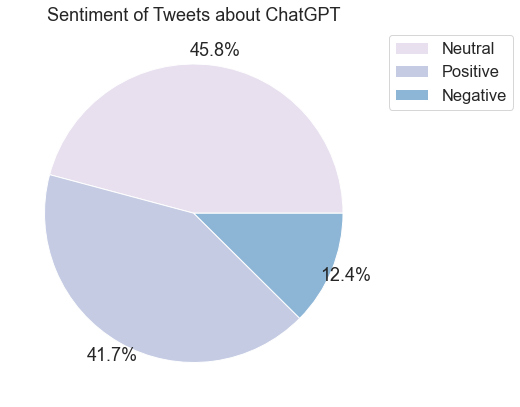

In [28]:
sns.set_palette('PuBuGn')
fig,ax=plt.subplots(1,1,figsize=(8,6))
pie = df_s['VADER_Sentiment'].value_counts()
plt.pie(pie, autopct="%.1f%%", pctdistance=1.1)
ax.legend(labels = pie.index, 
          bbox_to_anchor=[1,1])
ax.set_title('Sentiment of Tweets about ChatGPT')
plt.tight_layout()
plt.show()

## roBERTa Model

In [4]:
#load the model and tokenizer

model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
# function that takes text and model to calculate the probability of each sentiment
def sentiment_analyzer(tweet,model):
    #return the output of PyTorch tensors
    encoded_tweet = tokenizer(tweet, return_tensors='pt')   
    
    #calculate the sentiment
    output = model(**encoded_tweet)           
    
    #returning a NumPy array containing the embeddings of scores
    scores = output[0][0].detach().numpy()
    #normalize the scores to probability
    probability = np.round(softmax(scores),3)

    #calculate the polarity by multiply each probability to its weight(Negative:-1, Neutral:0, Positive:1)
    #define weight vector
    polarity_weights = torch.tensor([-1, 0, 1])
    
    #construct the tensor of probability
    probability = torch.tensor(probability)
    
    #calculate the polartiy score
    polarity = polarity_weights*probability
    
    # sum the weighted probabilities along the last dimension
    polarity = polarity.sum(dim=-1)
    
    #Scale polarity score to range [-1, 1]
    polarity_scaled = torch.nn.Tanh()(polarity)
    
    return round(polarity_scaled.item(),4)   

In [192]:
df_=df_s[0:1000].copy()

In [193]:
%%time
df_['Polarity']=df_['Text'].apply(lambda x: sentiment_analyzer(x,roberta_model))

CPU times: total: 3min 53s
Wall time: 51.3 s


In [257]:
sentiment_analyzer(df_s['Text'][49],roberta_model)

-0.1479

In [128]:
#as the roBERTa running will be quite long, will split the dataframe into chunks of 20k tweets each
n = 20000  #chunk row size
list_df = [df_s[i:i+n] for i in range(0,df_s.shape[0],n)]

In [243]:
list_df_2=[df_s[i:i+n].copy() for i in range(0,df_s.shape[0],n)]

In [129]:
len(list_df)

42

In [136]:
for df in list_df[40:]:
    print(df.shape)

(20000, 8)
(12924, 8)


In [ ]:
# the dataframe has been splitted into 41 groups with 20000 tweets and an extra one with the remainder (12924 tweets)
# will run the analysis over each one separately and then store in a csv file in case it crahses instead of redoing it again.
i = 8
for df in list_df_2[8:]:
    i = i+1
    df['ROBERTA_Polarity'] = df['Tweet'].apply(lambda x: sentiment_analyzer(x,roberta_model))
    df.to_csv(f'roberta_temp/chunk_{i}.csv')

In [46]:
import glob   
#list all cvs file into a list
cvs_list = glob.glob('roberta_temp/*.{}'.format(csv))

#concat all csv files into one dataframe
df_sentiment = pd.concat([pd.read_csv(file) for file in cvs_list])